# Object Detection with TDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(ticks=True, grid=True, gridlines='--')

#import scipy
from scipy import ndimage

from persim import plot_diagrams
from ripser import ripser, lower_star_img
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# My stuff
from utils import *

## Preprocessing

### Version 1 - Just use grayscale

In the future, it would be a good idea to use color in the model.

In [2]:
img_original = plt.imread('../data/testing/pipe_stack.png')

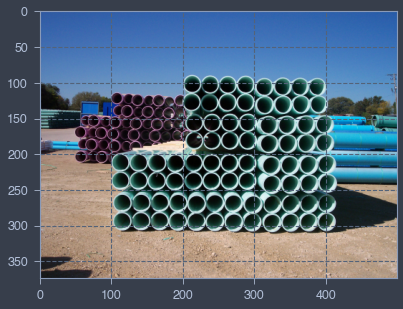

In [3]:
_ = plt.imshow(img_original)

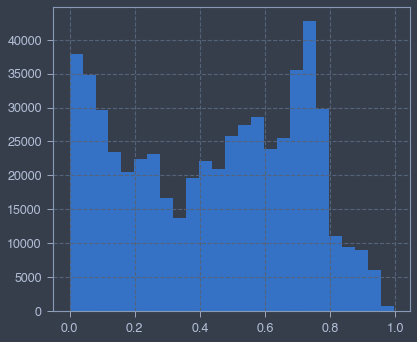

In [4]:
# Values between 0 and 1
_ = plt.hist(img_original.flatten(), bins=25)

In [5]:
# img has RGB values.
img_original.shape

(374, 500, 3)

In [6]:
# Flatten to grayscale using sum
img = img_original.sum(axis=2)
img.shape

(374, 500)

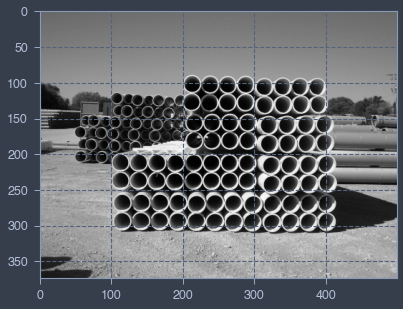

In [7]:
_ = plt.imshow(img, cmap='gray')

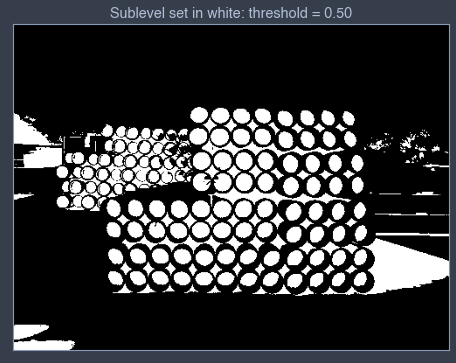

In [15]:
_ = plotSublevelMask(img, threshold=0.5)

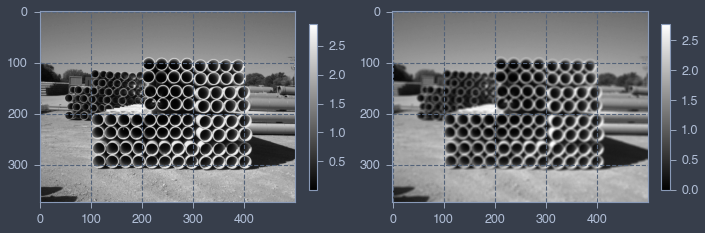

In [16]:
smoothed = ndimage.uniform_filter(img.astype(np.float64), size=5)
smoothed += 0.01 * np.random.randn(*smoothed.shape)

plt.figure(figsize=(10, 6))
plt.subplot(121)
im = plt.imshow(img, cmap='gray')
plt.colorbar(im, fraction=0.03)

plt.subplot(122)
im = plt.imshow(smoothed, cmap='gray')
plt.colorbar(im, fraction=0.03)

plt.tight_layout()

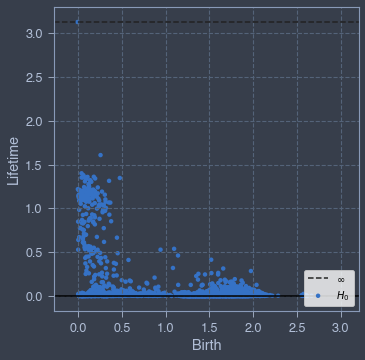

In [17]:
dgm = lower_star_img(smoothed)
plotPersistenceDiagrams(dgm, lifetime=True, colormap='default')

In [18]:
h0Comps = np.concatenate([dgm[:, 0].reshape(-1, 1), (dgm[:, 1] - dgm[:, 0]).reshape(-1, 1)], axis=1)
h0Comps = h0Comps[(np.isinf(h0Comps) == False).all(axis=1), :]

In [19]:
h0Comps2 = h0Comps[:, 1].reshape(-1, 1)

In [20]:
clusterAlgorithm = 'dbscan'
dataset = h0Comps2

if clusterAlgorithm == 'kmeans':
    model = KMeans(n_clusters=4).fit(dataset)
elif clusterAlgorithm == 'dbscan':
    model = DBSCAN(
        min_samples=10, # This needs to be tuned
        #p=10,
        eps=0.015 # Need to detect this
    ).fit(dataset)
elif clusterAlgorithm == 'agglom':
    model = AgglomerativeClustering(
        linkage='ward',
        distance_threshold=0.5,
        n_clusters=None
    ).fit(dataset)

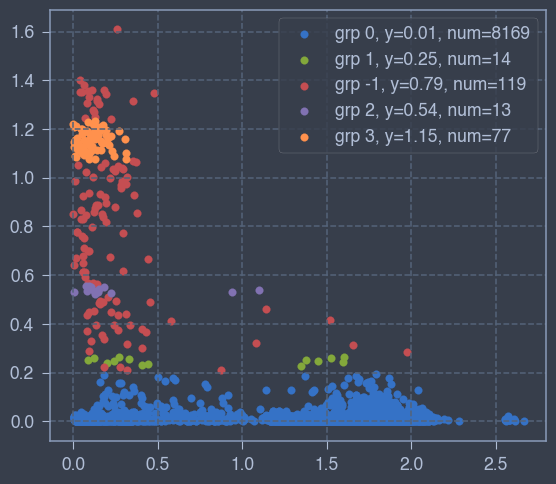

In [21]:
df = getLabeledDataset(h0Comps, model)
_ = plotClusterModel(df)

In [22]:
idxs = getObjectComponentIndexes(df)
components = getObjectComponents(df)

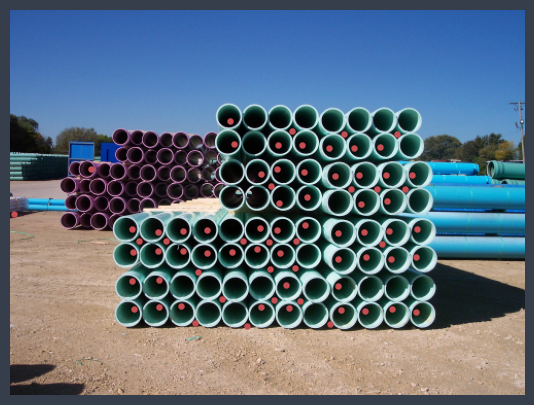

In [23]:
plt.figure(figsize=(8, 5))
plt.imshow(img_original)

#thresh = 0.6
#idxs = np.arange(dgm.shape[0])
#idxs = idxs[np.abs(dgm[:, 1] - dgm[:, 0]) > thresh]

# X and Y allow me to index every point in the image
X, Y = np.meshgrid(np.arange(smoothed.shape[1]), np.arange(smoothed.shape[0]))
X = X.flatten()
Y = Y.flatten()
bidxs = []

for idx in idxs:
    bidx = np.argmin(np.abs(smoothed - dgm[idx, 0]))
    bidxs.append(bidx)
    plt.scatter(X[bidx], Y[bidx], 20, 'r')

_=plt.axis('off')

## Ideas to improve

- Foreground detection / image segmentation
- Coaching the model which image it should look for (NN)
- auto-Tune parameters in preprocessing
- Use color (train model to ignore colors in background, etc.)